# Project 71: Automatic Caption Generation of Images

## Authors: Oihane Cantero and Julen Etxaniz

## Supervisors: Oier Lopez de Lacalle and Eneko Agirre

## Subject: Machine Learning and Neural Networks

## Date: 15-12-2020

## Objectives: 
### 1. Implement from scratch a caption generation model that uses a CNN to condition a LSTM based language model.
### 2. Extend the basic caption generation system that incorporates an attention mechanism to the model.

## Contents:
### Prepare Colab
### Import Libraries
### Prepare Photo Data
### Prepare Text Data
### Load Data
### Encode Text Data
### Define Model
### Fit Model
### Evaluate Model
### Generate Captions

# Prepare Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Ingeniaritza Informatikoa/4. Maila/1. Lauhilekoa/MLNN/Projects/Topic 3 Deep Neural Networks/neural-caption-generation/notebook

/content/drive/MyDrive/Ingeniaritza Informatikoa/4. Maila/1. Lauhilekoa/MLNN/Projects/Topic 3 Deep Neural Networks/neural-caption-generation/notebook


In [ ]:
%cd /content/drive/MyDrive/4/MLNN/P3/neural-caption-generation/notebook

/content/drive/.shortcut-targets-by-id/1yKqinuPu4oBVyhJ-8IMgknNyE2cmqrcs/neural-caption-generation/notebook


# Import Libraries



Prepare Photo Data

In [145]:
from os import listdir
from os.path import isfile
from pickle import dump
from tqdm import tqdm
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3 
# from keras.applications.inception_v3 import preprocess_input

Prepare Text Data

In [ ]:
import string

Load Data

In [ ]:
from numpy import array
from pickle import load

Encode Text Data

In [ ]:
from keras.preprocessing.text import Tokenizer

Define Model

In [108]:
from keras.utils import plot_model
from keras.models import Model
from keras.models import load_model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add

Fit Model

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Evaluate Model

In [ ]:
from numpy import argmax, argsort
from nltk.translate.bleu_score import corpus_bleu

Generate Captions

In [ ]:
from IPython.display import Image, display

# Prepare Photo Data

In [146]:
# cnn VGG16 model
def cnn_model_1():
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # summarize
    print(model.summary())
    plot_model(model, to_file='models/cnn_model_1.png', show_shapes=True)
    return model

In [147]:
# cnn InceptionV3 model
def cnn_model_2():
    # load the model
    model = InceptionV3()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # summarize
    print(model.summary())
    plot_model(model, to_file='models/cnn_model_2.png', show_shapes=True)
    return model

In [ ]:
# preprocess the image for the VGG model
def preprocess_image(filename):
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    return image

In [144]:
# extract features from each photo in the directory
def extract_features(directory):
	# get cnn model
	model = cnn_model_1()
	# extract features from each photo
	features = dict()
	for name in tqdm(listdir(directory), position=0, leave=True):
		# load an image from file
		filename = directory + '/' + name
		# preprocess the image for the VGG model
		image = preprocess_image(filename)
		# get features
		feature = model.predict(image, verbose=0)
		# get image id
		image_id = name.split('.')[0]
		# store feature
		features[image_id] = feature
	return features

In [ ]:
# extract features from all images
directory = 'Flickr8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))

In [ ]:
# save to file
filename = 'files/features.pkl'
if not isfile(filename):
	dump(features, open(filename, 'wb'))

In [150]:
cnn_model_1()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

In [149]:
cnn_model_2()

96116736/96112376 [==============================] - 0s 0us/step
Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_22[0][0]                   
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_____________________

# Prepare Text Data

In [ ]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [ ]:
# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

In [ ]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

In [ ]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

In [ ]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

In [142]:
filename = 'Flickr8k_text/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, 'files/descriptions.txt')

Loaded: 8092 
Vocabulary Size: 8763


# Load Data

In [ ]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

In [ ]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

In [ ]:
# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

In [ ]:
# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('files/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('files/features.pkl', train)
print('Photos: train=%d' % len(train_features))

Dataset: 6000
Descriptions: train=6000
Photos: train=6000


In [ ]:
# load val dataset
filename = 'Flickr8k_text/Flickr_8k.devImages.txt'
val = load_set(filename)
print('Dataset: %d' % len(val))
# descriptions
val_descriptions = load_clean_descriptions('files/descriptions.txt', val)
print('Descriptions: val=%d' % len(val_descriptions))
# photo features
val_features = load_photo_features('files/features.pkl', val)
print('Photos: val=%d' % len(val_features))

Dataset: 1000
Descriptions: val=1000
Photos: val=1000


# Encode Text Data

In [ ]:
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

In [ ]:
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [ ]:
# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

In [ ]:
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
filename = 'files/tokenizer.pkl'
if not isfile(filename):
	dump(tokenizer, open(filename, 'wb'))
# define vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Vocabulary Size: 7579
Description Length: 34


# Define Model

In [105]:
# define the captioning model
def rnn_model_1(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
	print(model.summary())
	plot_model(model, to_file='models/rnn_model_1.png', show_shapes=True)
	return model

In [121]:
from keras.layers import RepeatVector, TimeDistributed, concatenate, Bidirectional
# define the captioning model
def rnn_model_2(vocab_size, max_length):
    image_input = Input(shape=(4096,))
    image_model_1 = Dense(256, activation='relu')(image_input)
    image_model = RepeatVector(max_length)(image_model_1)

    caption_input = Input(shape=(max_length,))
    # mask_zero: We zero pad inputs to the same length, the zero mask ignores those inputs. E.g. it is an efficiency.
    caption_model_1 = Embedding(vocab_size, 256, mask_zero=True)(caption_input)
    # Since we are going to predict the next word using the previous words
    # (length of previous words changes with every iteration over the caption), we have to set return_sequences = True.
    caption_model_2 = LSTM(256, return_sequences=True)(caption_model_1)
    # caption_model = TimeDistributed(Dense(256, activation='relu'))(caption_model_2)
    caption_model = TimeDistributed(Dense(256))(caption_model_2)

    # Merging the models and creating a softmax classifier
    final_model_1 = concatenate([image_model, caption_model])
    # final_model_2 = LSTM(256, return_sequences=False)(final_model_1)
    final_model_2 = Bidirectional(LSTM(256, return_sequences=False))(final_model_1)
    # final_model_3 = Dense(256, activation='relu')(final_model_2)
    # final_model = Dense(vocab_size, activation='softmax')(final_model_3)
    final_model = Dense(vocab_size, activation='softmax')(final_model_2)

    model = Model(inputs=[image_input, caption_input], outputs=final_model)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    # summarize model
    print(model.summary())
    plot_model(model, to_file='models/rnn_model_2.png', show_shapes=True)
    return model

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()

In [ ]:
# define the model
model = rnn_model_1(vocab_size, max_length)

In [122]:
# define the model
model = rnn_model_2(vocab_size, max_length)

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 34, 256)      1940224     input_17[0][0]                   
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 256)          1048832     input_16[0][0]                   
_______________________________________________________________________________________

# Fit Model

In [ ]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
	X1, X2, y = list(), list(), list()
	# walk through each description for the image
	for desc in desc_list:
		# encode the sequence
		seq = tokenizer.texts_to_sequences([desc])[0]
		# split one sequence into multiple X,y pairs
		for i in range(1, len(seq)):
			# split into input and output pair
			in_seq, out_seq = seq[:i], seq[i]
			# pad input sequence
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			# encode output sequence
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			# store
			X1.append(photo)
			X2.append(in_seq)
			y.append(out_seq)
	return array(X1), array(X2), array(y)

In [ ]:
# data generator, intended to be used in a call to model.fit()
def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
	# loop for ever over images
	while 1:
		for key, desc_list in descriptions.items():
			# retrieve the photo feature
			photo = photos[key][0]
			in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
			yield ([in_img, in_seq], out_word)

In [ ]:
# train the model, run epochs manually and save after each epoch
epochs = 20
train_steps = len(train_descriptions)
val_steps = len(val_descriptions)
for i in range(epochs):
	# create the train data generator
	generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
	# create the validation data generator
	validation_generator = data_generator(val_descriptions, val_features, tokenizer, max_length, vocab_size)
	# fit for one epoch
	model.fit(generator, validation_data=validation_generator, validation_steps=val_steps, epochs=1, steps_per_epoch=train_steps, verbose=1)
	# save model
	model.save('models/model_' + str(i) + '.h5')

# Fit Model Batch

In [ ]:
# Create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, captions_list, image):
	# X1 : input for image features
	# X2 : input for text features
	# y  : output word
	X1, X2, y = list(), list(), list()
	vocab_size = len(tokenizer.word_index) + 1
	# Walk through each caption for the image
	for caption in captions_list:
		# Encode the sequence
		seq = tokenizer.texts_to_sequences([caption])[0]
		# Split one sequence into multiple X,y pairs
		for i in range(1, len(seq)):
			# Split into input and output pair
			in_seq, out_seq = seq[:i], seq[i]
			# Pad input sequence
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			# Encode output sequence
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			# Store
			X1.append(image)
			X2.append(in_seq)
			y.append(out_seq)
	return X1, X2, y

In [ ]:
import numpy as np
# Data generator, intended to be used in a call to model.fit_generator()
def data_generator(images, captions, tokenizer, max_length, batch_size, random_seed):
	# Setting random seed for reproducibility of results
	random.seed(random_seed)
	# Image ids
	image_ids = list(captions.keys())
	_count=0
	assert batch_size<= len(image_ids), 'Batch size must be less than or equal to {}'.format(len(image_ids))
	while True:
		if _count >= len(image_ids):
			# Generator exceeded or reached the end so restart it
			_count = 0
		# Batch list to store data
		input_img_batch, input_sequence_batch, output_word_batch = list(), list(), list()
		for i in range(_count, min(len(image_ids), _count+batch_size)):
			# Retrieve the image id
			image_id = image_ids[i]
			# Retrieve the image features
			image = images[image_id][0]
			# Retrieve the captions list
			captions_list = captions[image_id]
			# Shuffle captions list
			random.shuffle(captions_list)
			input_img, input_sequence, output_word = create_sequences(tokenizer, max_length, captions_list, image)
			# Add to batch
			for j in range(len(input_img)):
				input_img_batch.append(input_img[j])
				input_sequence_batch.append(input_sequence[j])
				output_word_batch.append(output_word[j])
		_count = _count + batch_size
		yield ([np.array(input_img_batch), np.array(input_sequence_batch)], np.array(output_word_batch))

In [ ]:
import random
# Setting random seed for reproducibility of results
random.seed('1000')

In [99]:
num_of_epochs = 20
batch_size = 32
train_length = len(train_descriptions)
val_length = len(val_descriptions)
steps_train = train_length // batch_size
if train_length % batch_size != 0:
    steps_train = steps_train+1
steps_val = val_length // batch_size
if val_length % batch_size != 0:
    steps_val = steps_val+1

print(steps_train)
print(steps_val)

188
32


In [159]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
# define checkpoint callback
# filepath = 'models/model-ep{epoch:02d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
filepath = 'models/rnn_model_2.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(patience=1, verbose=1)

In [160]:
# Shuffle train data
ids_train = list(train_descriptions.keys())
random.shuffle(ids_train)
train_descriptions = {_id: train_descriptions[_id] for _id in ids_train}

In [ ]:
# Create the train data generator
generator_train = data_generator(train_features, train_descriptions, tokenizer, max_length, batch_size, random_seed='1000')
# Create the validation data generator
generator_val = data_generator(val_features, val_descriptions, tokenizer, max_length, batch_size, random_seed='1000')

# Fit
history = model.fit(generator_train,
            epochs=num_of_epochs,
            steps_per_epoch=steps_train,
            validation_data=generator_val,
            validation_steps=steps_val,
            callbacks=[checkpoint, early],
            verbose=1)

In [125]:
loss_history = history.history["loss"]
val_loss_history = history.history["val_loss"]
print(loss_history)
print(val_loss_history)

[5.9239397048950195, 5.365537643432617, 4.64870548248291, 4.043129920959473, 3.712960720062256, 3.487694263458252, 3.3069350719451904, 3.15433931350708, 3.018089532852173, 2.90333890914917, 2.8014214038848877, 2.6971991062164307, 2.6074304580688477]
[5.610720157623291, 5.03642463684082, 4.314327239990234, 3.9924347400665283, 3.8465006351470947, 3.7754099369049072, 3.728360176086426, 3.6851725578308105, 3.667895555496216, 3.6657843589782715, 3.656430244445801, 3.660112142562866, 3.670562982559204]


In [ ]:
loss_history = history.history["loss"]
val_loss_history = history.history["val_loss"]
print(loss_history)
print(val_loss_history)

[4.484209060668945, 3.8293654918670654, 3.5078959465026855, 3.2791800498962402, 3.101055383682251]
[4.123674392700195, 3.8948781490325928, 3.8423359394073486, 3.8460443019866943, 3.8676846027374268]


# Evaluate Model

In [ ]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

In [ ]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

In [ ]:
# generate a description for an image using beam search
def generate_desc_beam_search(model, tokenizer, photo, max_length, beam_index=3):
    # seed the generation process
    in_text = [['startseq', 0.0]]
    # iterate over the whole length of the sequence
    for i in range(max_length):
        temp = []
        for s in in_text:
            # integer encode input sequence
            sequence = tokenizer.texts_to_sequences([s[0]])[0]
            # pad input
            sequence = pad_sequences([sequence], maxlen=max_length)
            # predict next words
            preds = model.predict([photo,sequence], verbose=0)
            word_preds = argsort(preds[0])[-beam_index:]
            # get top predictions
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                # map integer to word
                word = word_for_id(w, tokenizer)
                next_cap += ' ' + word
                prob += preds[0][w]
                temp.append([next_cap, prob])

        in_text = temp
        # sorting according to the probabilities
        in_text = sorted(in_text, reverse=False, key=lambda l: l[1])
        # getting the top words
        in_text = in_text[-beam_index:]

    # get last caption text
    in_text = in_text[-1][0]
    caption_list = []
    # remove leftover endseq 
    for w in in_text.split():
        caption_list.append(w)
        if w == 'endseq':
            break
    # convert list to string
    caption = ' '.join(caption_list)
    return caption

In [ ]:
def calculate_scores(actual, predicted):
    # calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [140]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in tqdm(descriptions.items(), position=0, leave=True):
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	print('Sampling:')
	calculate_scores(actual, predicted)

In [139]:
# evaluate the skill of the model
def evaluate_model_beam_search(model, descriptions, photos, tokenizer, max_length, beam_index=3):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in tqdm(descriptions.items(), position=0, leave=True):
		# generate description
		yhat = generate_desc_beam_search(model, tokenizer, photos[key], max_length, beam_index)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	print('Beam Search k=%d:' % beam_index)
	calculate_scores(actual, predicted)

In [ ]:
# load test set
filename = 'Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('files/descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('files/features.pkl', test)
print('Photos: test=%d' % len(test_features))

Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [ ]:
# load the model
filename = 'models/rnn_model_1.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

In [126]:
# load the model
filename = 'models/rnn_model_2.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Sampling:
BLEU-1: 0.595796
BLEU-2: 0.369997
BLEU-3: 0.272431
BLEU-4: 0.144684


In [151]:
# load the model
filename = 'models/rnn_model_2.h5'
model = load_model(filename)

In [ ]:
evaluate_model_beam_search(model, test_descriptions, test_features, tokenizer, max_length, beam_index=3)

# Generate Captions

In [153]:
# load the model
filename = 'models/rnn_model_2.h5'
rnn_model = load_model(filename)
# load the tokenizer
tokenizer = load(open('files/tokenizer.pkl', 'rb'))

In [154]:
def clean_caption(caption):
    # split caption words
    caption_list = caption.split()
    # remove startseq and endseq
    caption_list = caption_list[1:len(caption_list)-1]
    # convert list to string
    caption = ' '.join(caption_list)
    return caption

In [155]:
def generate_captions(directory):
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    for name in listdir(directory):
        # load an image from file
        filename = directory + '/' + name
        # preprocess the image for the VGG model
        image = preprocess_image(filename)
        # get features
        feature = model.predict(image, verbose=0)
        #diplay image
        display(Image(filename))
        # generate descriptions
        print('Sampling: ' + clean_caption(generate_desc(rnn_model, tokenizer, feature, max_length)))
        print('Beam Search k=3: ' + clean_caption(generate_desc_beam_search(rnn_model, tokenizer, feature, max_length, beam_index=3)))
        print('Beam Search k=5: ' + clean_caption(generate_desc_beam_search(rnn_model, tokenizer, feature, max_length, beam_index=5)))
        print('Beam Search k=7: ' + clean_caption(generate_desc_beam_search(rnn_model, tokenizer, feature, max_length, beam_index=7)))

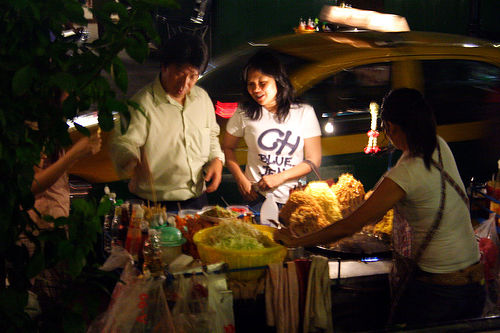

Sampling: man is eating up an arcade
Beam Search k=3: two people are looking at table in front of store
Beam Search k=5: group of people are standing in front of bus
Beam Search k=7: group of people are standing in front of bus


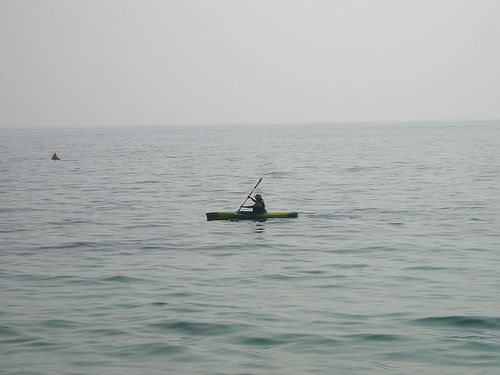

Sampling: man is paddling boat in the water
Beam Search k=3: two people are on boat in the water
Beam Search k=5: man kayaks in the water
Beam Search k=7: man kayaks in the water


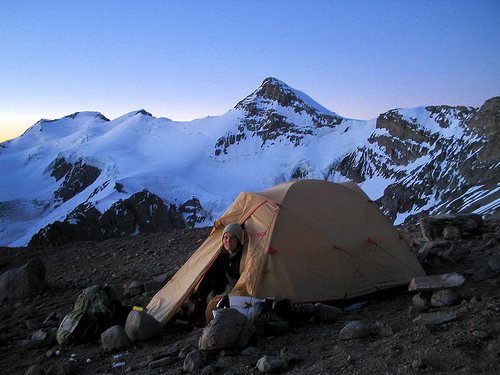

Sampling: man is standing on snowy mountain
Beam Search k=3: man stands in the snow with mountains in the background
Beam Search k=5: mountain climber is standing in the snow with mountains in the background
Beam Search k=7: the skier is standing in the snow


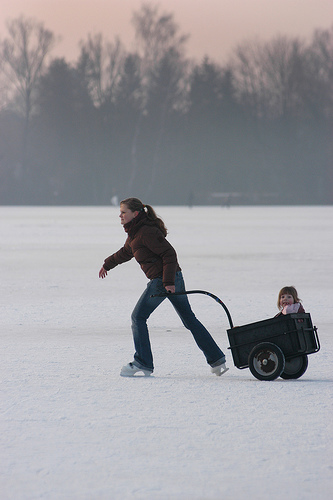

Sampling: man is pulling up buggy into the snow
Beam Search k=3: man is standing on the edge of the snow
Beam Search k=5: man is standing on the edge of large ice
Beam Search k=7: man is standing on the edge of large ice


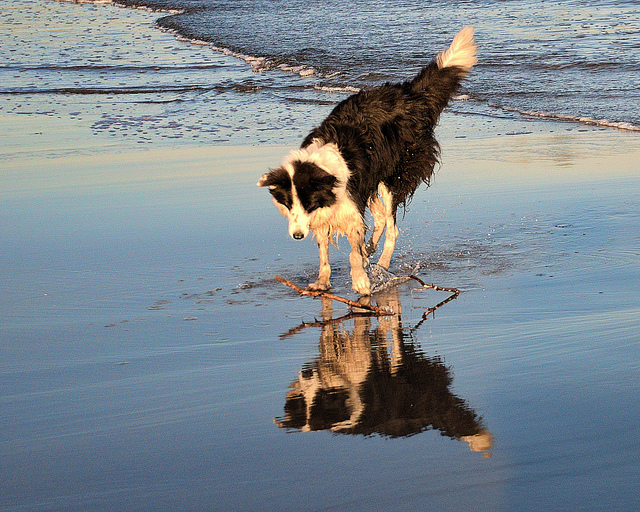

Sampling: dog is running in the water
Beam Search k=3: black and black dog is running in the water
Beam Search k=5: the black and white dog is running on the beach
Beam Search k=7: the black and white dog is walking through the water


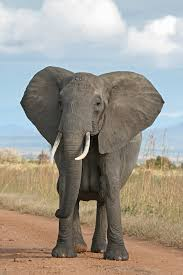

Sampling: man in black shirt and black pants stands on the top of wooden wall
Beam Search k=3: man stands in front of large animal
Beam Search k=5: man is standing in front of large animal
Beam Search k=7: man is standing in front of mountain


In [156]:
generate_captions('images')

553467904/553467096 [==============================] - 4s 0us/step


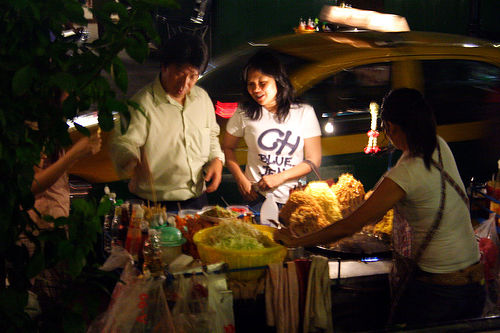

Sampling: man in red shirt and black and white shirt is standing in front of building
Beam Search k=3: man in red shirt and black and white jacket is standing in front of building
Beam Search k=5: group of people are standing in front of people
Beam Search k=7: group of people are standing in front of people


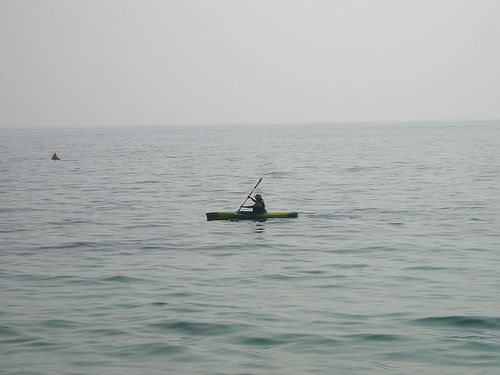

Sampling: man in red shirt is riding the wave
Beam Search k=3: the man in the yellow shirt is in the water
Beam Search k=5: the man in the yellow shirt is in the water
Beam Search k=7: the man in the yellow shirt is in the water


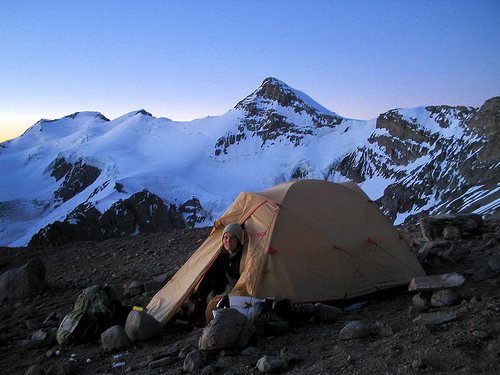

Sampling: man in red shirt is riding the rapids
Beam Search k=3: man in red shirt and red backpack is standing in the mountains
Beam Search k=5: the man in the red shirt is in the snow
Beam Search k=7: group of people are sitting on the top of waterfall


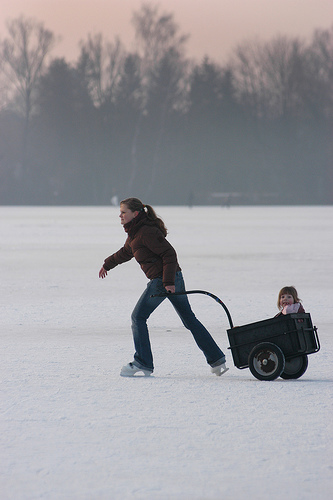

Sampling: man in red shirt is standing on the beach
Beam Search k=3: the man in the blue shirt is in the water
Beam Search k=5: the man is in the water
Beam Search k=7: the man is sitting on the edge of waterfall


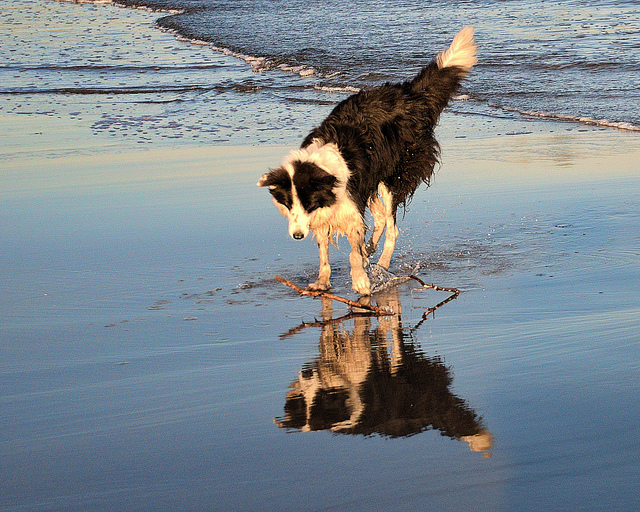

Sampling: two dogs are running through the water
Beam Search k=3: black and white dog runs through the water


In [ ]:
generate_captions('images')